#### CSC 180 Intelligent Systems 

#### William Lorence, Ajaydeep Singh, Romin Akoliya, Abdurraziq Paikur

#### California State University, Sacramento


# Project 2: Modern Low Footprint Cyber Attack Protection
## Reading the Data
The code below reads the data from the dataset and creates dataframes. Values of "-" are treated as N/A and entries with this value are dropped from the dataframe. Attack_cat is also dropped due to the fact that it gives additional information to the model that we do not want (skewing the accuracy).

In [283]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from collections.abc import Sequence
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

path = "./dataset/"
save_path = "./models/"

#Defines filepaths for the data sets
training_set = os.path.join(path,"UNSW_NB15_training-set.csv")
test_set = os.path.join(path,"UNSW_NB15_test-set.csv")

#Loads files into dataframes
df_training_set = pd.read_csv(training_set, na_values = ['-'])
df_test_set = pd.read_csv(test_set, na_values = ['-'])

#Removes rows with a "-" in any column
df_training_set.dropna(inplace = True)
df_test_set.dropna(inplace = True)

df_training_set.drop('attack_cat', axis = 1, inplace = True)
df_test_set.drop('attack_cat', axis = 1, inplace = True)

print(len(df_training_set))
print(len(df_test_set))

df_training_set.head()

81173
35179


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,1,3,1,1,0,2,1,0,0
11,12,2.093085,tcp,smtp,FIN,62,28,56329,2212,42.520967,...,1,1,2,0,0,0,1,1,0,0
15,16,0.000002,udp,snmp,INT,2,0,138,0,500000.001300,...,1,1,4,0,0,0,2,1,0,0
17,18,0.393556,tcp,http,FIN,10,8,860,1096,43.195886,...,1,1,2,0,0,1,1,3,0,0
21,22,0.338017,tcp,http,FIN,10,6,998,268,44.376468,...,1,1,1,0,0,1,2,3,0,0


## Data Filtering
The code below removes categorical values that are not present in both datasets. As visible via the print statements, roughly 600 entries are dropped from the training set, while only one is dropped from the test set.

In [284]:
#Removes categorical values not present in both datasets
categorical_columns = ['proto', 'service', 'state']

for column in categorical_columns:
    unique_values_training = set(df_training_set[column].unique())
    unique_values_test = set(df_test_set[column].unique())

    print(unique_values_training)
    print(unique_values_test)
    
    common_values = unique_values_training.intersection(unique_values_test)
    print(common_values)

    df_training_set = df_training_set[df_training_set[column].isin(common_values)]
    df_test_set = df_test_set[df_test_set[column].isin(common_values)]

print(len(df_training_set))
print(len(df_test_set))

{'udp', 'tcp'}
{'udp', 'tcp'}
{'tcp', 'udp'}
{'ssl', 'pop3', 'dns', 'smtp', 'dhcp', 'snmp', 'irc', 'ftp-data', 'ftp', 'radius', 'http', 'ssh'}
{'ssl', 'pop3', 'dns', 'smtp', 'dhcp', 'snmp', 'irc', 'ftp-data', 'ftp', 'radius', 'http', 'ssh'}
{'ssl', 'pop3', 'dns', 'smtp', 'dhcp', 'snmp', 'irc', 'ftp-data', 'ftp', 'radius', 'http', 'ssh'}
{'FIN', 'CON', 'INT', 'RST', 'REQ'}
{'ACC', 'FIN', 'CON', 'INT', 'REQ'}
{'CON', 'FIN', 'REQ', 'INT'}
81159
35178


The columns 'id' and 'is_sm_ips_ports' are dropped from the dataframes: 'id' is irrelevent to the data at hand, and 'is_sm_ips_ports' causes errors when calculating z scores (likely because it is always 0).

In [285]:
df_training_set.drop('id', axis = 1, inplace = True)
df_training_set.drop('is_sm_ips_ports', axis = 1, inplace = True)

df_test_set.drop('id', axis = 1, inplace = True)
df_test_set.drop('is_sm_ips_ports', axis = 1, inplace = True)

The numerical data is then normalized via z-score.

In [286]:
#Finds numerical data (columns that are not categorical)
non_z_columns = ['proto', 'service', 'state', 'label']
numerical_columns = set(df_training_set.columns.symmetric_difference(non_z_columns))

from scipy.stats import zscore

def z_score_numerical(df, names):
    for name in names:
        df[name] = zscore(df[name])

z_score_numerical(df_training_set, numerical_columns)
z_score_numerical(df_test_set, numerical_columns)

Finally, the next bit of code encodes the now-filtered categorical values into their own columns.

In [287]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue) given a dataframe and a list of column names
def encode_text_dummy_loop(df, names):
    for name in names:
        dummies = pd.get_dummies(df[name])
        for x in dummies.columns:
            dummy_name = "{}-{}".format(name, x)
            df[dummy_name] = dummies[x]
        df.drop(name, axis=1, inplace=True)

encode_text_dummy_loop(df_training_set, categorical_columns)
encode_text_dummy_loop(df_test_set, categorical_columns)

df_training_set.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl,state-CON,state-FIN,state-INT,state-REQ
3,0.176163,-0.047988,-0.044583,-0.055887,-0.077790,-0.624202,-1.042388,1.554525,-0.610177,-0.216555,...,False,False,False,False,False,False,False,True,False,False
11,0.267845,0.216818,0.076667,0.169739,-0.069504,-0.624034,-1.042388,1.554525,-0.607597,-0.211860,...,False,False,True,False,False,False,False,True,False,False
15,-0.198561,-0.100949,-0.135522,-0.057872,-0.082214,2.286835,0.822749,-0.717536,2.795602,-0.219844,...,False,False,False,True,False,False,False,False,True,False
17,-0.110864,-0.058580,-0.074896,-0.054948,-0.075916,-0.624030,-1.042388,1.554525,-0.610017,-0.200752,...,False,False,False,False,False,False,False,True,False,False
21,-0.123240,-0.058580,-0.090053,-0.054389,-0.080674,-0.624023,0.822749,1.554525,-0.609948,-0.214652,...,False,False,False,False,False,False,False,True,False,False


The data is now mostly ready, just needing to be formatted in X y.

In [288]:
# Ensure both sets have the same columns after encoding
df_training_set, df_test_set = df_training_set.align(df_test_set, join='inner', axis=1)

# Features (X) and Target (y)
X_train = df_training_set.drop('label', axis=1)
y_train = df_training_set['label']
X_test = df_test_set.drop('label', axis=1)
y_test = df_test_set['label']

# Check data shapes
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Training set shape: (81159, 56)
Test set shape: (35178, 56)


# Model Creation and Training
First, we create a traditional FCNN model using relu and sigmoid (for the final classification layer). The model is then trained.

In [289]:
# Define FCNN Model Function
def create_fcnn(input_shape=(X_train.shape[1],), activation='relu', neuron_count_array=[64,32]):
    model = Sequential()
    model.add(Dense(neuron_count_array[0], activation=activation, input_shape=(input_shape))) # Initial layer, with input shape
    for i in range(len(neuron_count_array)-1):
        model.add(Dense(neuron_count_array[i+1], activation=activation))    #In between layers
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create FCNN Model
model_fcnn = create_fcnn((X_train.shape[1],))

def train_model_fcnn(model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
    # Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Define callbacks for early stopping & model checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath=os.path.join(save_path, 'fcnn_best_model.keras'), save_best_only=True)

    # Train the model
    history_fcnn = model_fcnn.fit(X_train, y_train, 
                                validation_split=0.2, 
                                    epochs=50, 
                                    batch_size=32, 
                                    callbacks=[early_stopping, model_checkpoint])

train_model_fcnn(model_fcnn)
model_fcnn.summary()

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 522us/step - accuracy: 0.9653 - loss: 0.1104 - val_accuracy: 0.9986 - val_loss: 0.0071
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.9757 - loss: 0.0577 - val_accuracy: 0.9980 - val_loss: 0.0070
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.9766 - loss: 0.0519 - val_accuracy: 0.9983 - val_loss: 0.0065
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - accuracy: 0.9792 - loss: 0.0496 - val_accuracy: 0.9994 - val_loss: 0.0040
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9779 - loss: 0.0501 - val_accuracy: 0.9988 - val_loss: 0.0049
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9794 - loss: 0.0483 - val_accuracy: 0.9959 - val_loss: 0.0090
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.9784 - loss: 0.0491 - val_accuracy: 0.9978 - val_loss: 0.0064


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_155 (Dense)               │ (None, 64)             │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,285 (67.52 KB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,524 (45.02 KB)

Next, we create a CNN model (which includes kernels). The same procedure is used.

In [290]:
# Define CNN Model Function
def create_cnn(input_shape=(X_train.shape[1], 1), activation='relu', neuron_count_array=[64,32], kernel_size_array=[3,3]):
    model = Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=kernel_size_array[0], activation=activation, input_shape=(input_shape)))
    for i in range(len(kernel_size_array)-1):
        model.add(layers.Conv1D(filters=64, kernel_size=kernel_size_array[i+1], activation=activation))
        model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    for j in range(len(neuron_count_array)-1):
        model.add(Dense(neuron_count_array[j], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create CNN Model
model_cnn = create_cnn((X_train.shape[1], 1))

#Compile and train model
def train_model_cnn(model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
    # Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Define callbacks for early stopping & model checkpoint
    early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint_cnn = ModelCheckpoint(filepath=os.path.join(save_path, 'cnn_best_model.keras'), save_best_only=True)

    # Train the model
    history_cnn = model.fit(X_train, y_train, 
                                epochs=50, 
                                batch_size=32, 
                                validation_split=0.2,  # Use 20% of training data for validation
                                callbacks=[early_stopping_cnn, model_checkpoint_cnn])

train_model_cnn(model_cnn)
model_cnn.summary()

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9663 - loss: 0.0996 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9773 - loss: 0.0554 - val_accuracy: 0.9986 - val_loss: 0.0049
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9785 - loss: 0.0527 - val_accuracy: 0.9963 - val_loss: 0.0080
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9800 - loss: 0.0473 - val_accuracy: 0.9991 - val_loss: 0.0032


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 54, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 52, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 26, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 64)             │       106,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,885 (1.29 MB)

 Trainable params: 112,961 (441.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 225,924 (882.52 KB)

# Evaluating the Models
The following function will allow us to evaluate our models given test data. It prints the confusion matrix as well as the ROC.

In [291]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_data):
    # Make predictions on the test set
    y_pred = model.predict(test_data)
    # Convert probabilities to binary predictions if your model outputs probabilities
    y_pred_classes = (y_pred > 0.5).astype(int)  # Use the appropriate threshold

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    # Print the results
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Get the probability predictions
    y_pred_prob = model.predict(test_data)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()



This is the evaluation of the FCNN model.

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
Confusion Matrix:
 [[ 7539  2085]
 [  170 25384]]
Precision: 0.9240962539590083
Recall: 0.9933474211473742
F1-Score: 0.9574712860456783


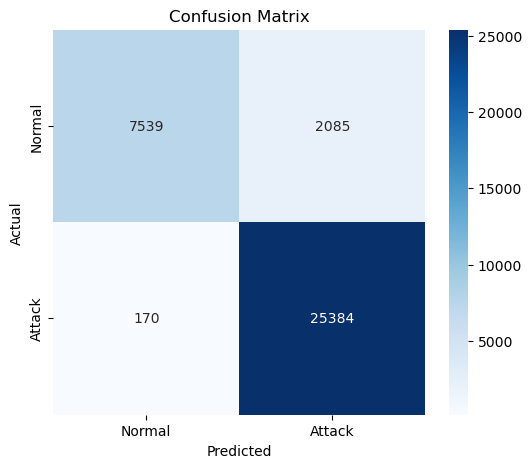

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


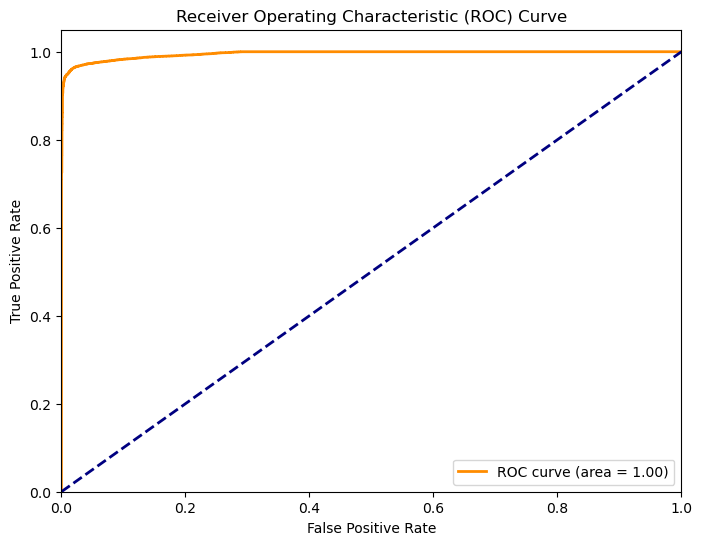

In [292]:
evaluate_model(model_fcnn, X_test)

This is the evaluation of the CNN model.

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step
Confusion Matrix:
 [[ 7110  2514]
 [    6 25548]]
Precision: 0.9104126576865512
Recall: 0.999765203099319
F1-Score: 0.9529991047448523


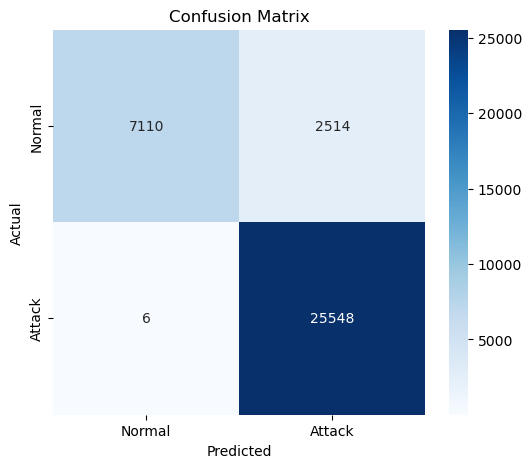

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step


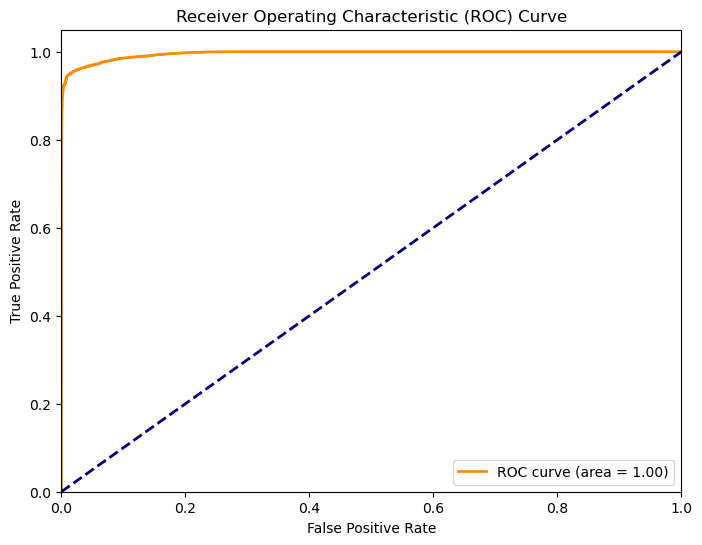

In [293]:
evaluate_model(model_cnn, X_test)

With these two initial models complete, the rest of this notebook contains models with different activation methods, layer counts/sizes, and kernel counts/sizes (when applicable).
# Model Experimentation

### FCNN, ReLU, 64->32->16, Adam

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 570us/step - accuracy: 0.9524 - loss: 0.1377 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.9768 - loss: 0.0563 - val_accuracy: 0.9978 - val_loss: 0.0074
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.9768 - loss: 0.0534 - val_accuracy: 0.9957 - val_loss: 0.0102
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.9768 - loss: 0.0548 - val_accuracy: 0.9966 - val_loss: 0.0078
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
Confusion Matrix:
 [[ 6860  2764]
 [  101 25453]]
Precision: 0.9020448665697983
Recall: 0.9960475855052047
F1-Score: 0.946718491380112


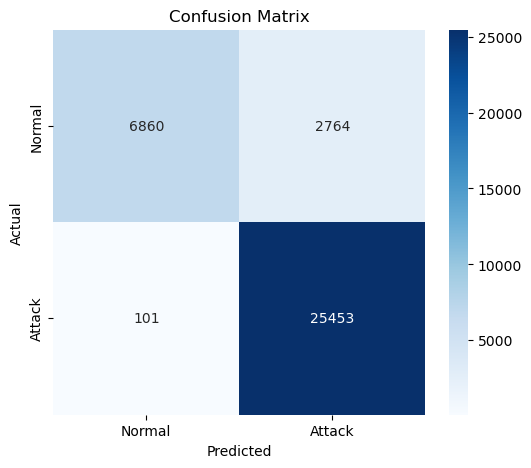

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


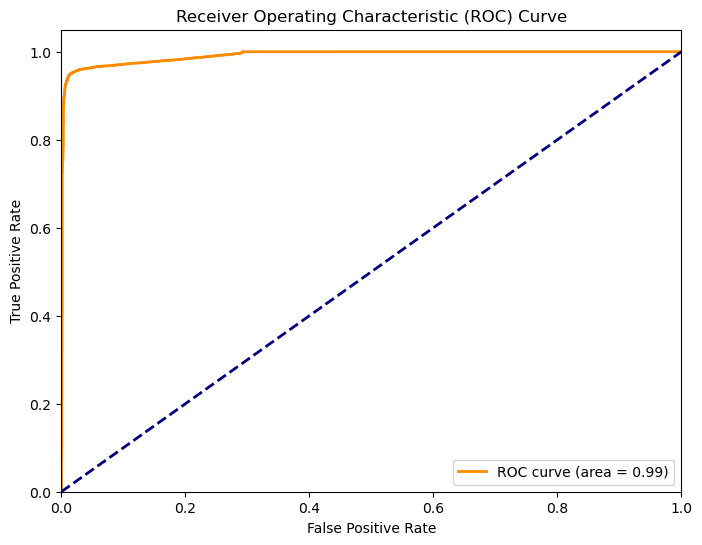

In [296]:
model = create_fcnn(activation='relu', neuron_count_array=[64, 32, 16])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### FCNN, ReLU, 64->32->16, SGD

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.9283 - loss: 0.2566 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - accuracy: 0.9732 - loss: 0.0832 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.9721 - loss: 0.0770 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - accuracy: 0.9735 - loss: 0.0692 - val_accuracy: 0.9996 - val_loss: 0.0083
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - accuracy: 0.9750 - loss: 0.0638 - val_accuracy: 0.9996 - val_loss: 0.0059
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.9756 - loss: 0.0586 - val_accuracy: 0.9988 - val_loss: 0.0079
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.9772 - loss: 0.0560 - val_accuracy: 0.9982 - val_loss: 0.0073
Epoch 8/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - accuracy: 0.9761 - loss: 0.05

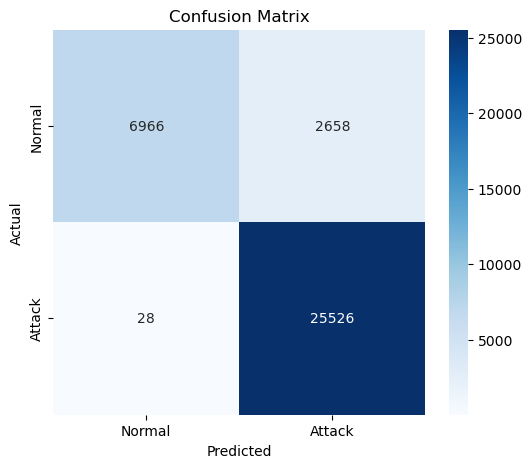

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


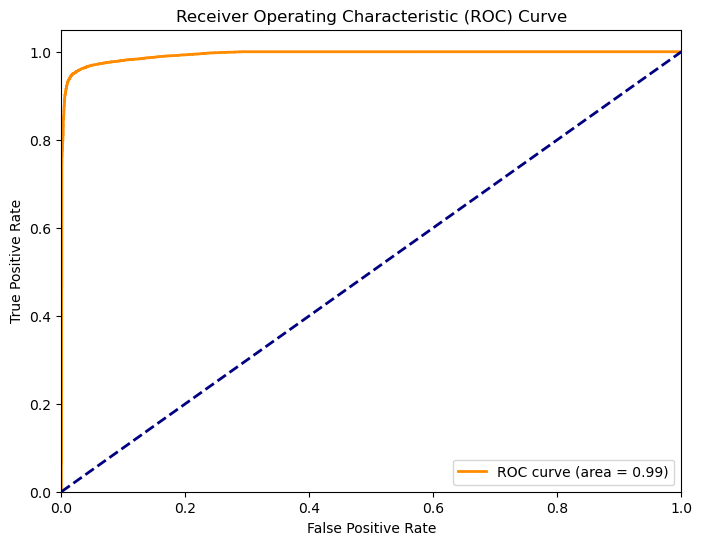

In [297]:
model = create_fcnn(activation='relu', neuron_count_array=[64, 32, 16])
train_model_cnn(model, optimizer='sgd')
evaluate_model(model, X_test)

### FCNN, tanh, 64->32, Adam

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 538us/step - accuracy: 0.9559 - loss: 0.1180 - val_accuracy: 0.9994 - val_loss: 0.0062
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - accuracy: 0.9753 - loss: 0.0584 - val_accuracy: 0.9964 - val_loss: 0.0083
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.9771 - loss: 0.0542 - val_accuracy: 0.9974 - val_loss: 0.0073
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.9784 - loss: 0.0533 - val_accuracy: 0.9988 - val_loss: 0.0051
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.9779 - loss: 0.0507 - val_accuracy: 0.9992 - val_loss: 0.0051
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.9780 - loss: 0.0511 - val_accuracy: 0.9969 - val_loss: 0.0074
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.9790 - loss: 0.0495 - val_accuracy: 0.9993 - val_loss: 0.0035
Epoch 8/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.9795 - loss: 0.04

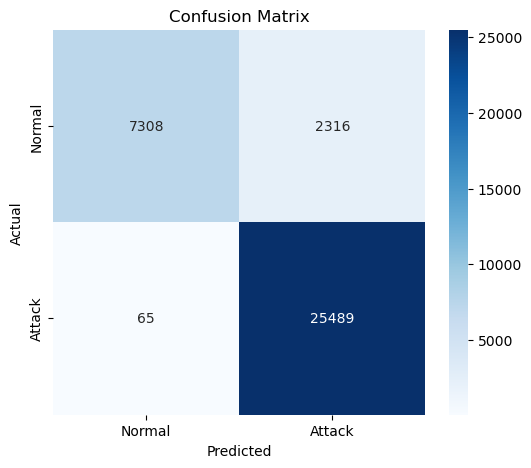

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


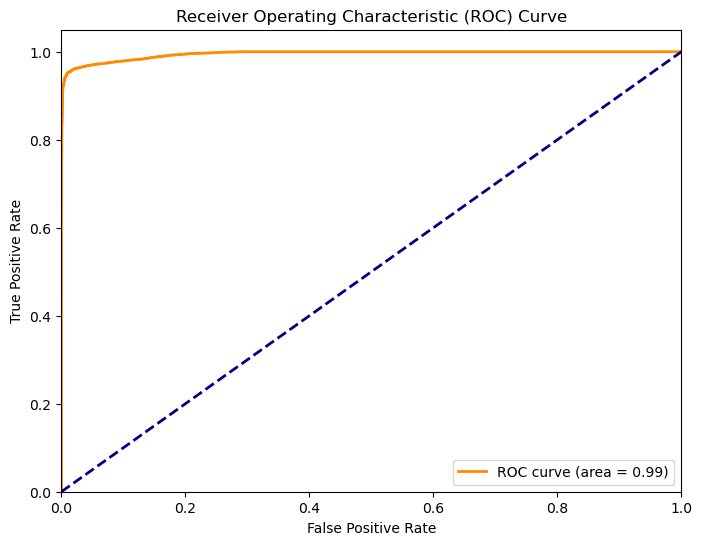

In [312]:
model = create_fcnn(activation='tanh', neuron_count_array=[64, 32])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### FCNN, tanh, 64->32, SGD

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.9281 - loss: 0.2120 - val_accuracy: 0.9998 - val_loss: 0.0119
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - accuracy: 0.9715 - loss: 0.0909 - val_accuracy: 0.9999 - val_loss: 0.0075
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.9731 - loss: 0.0758 - val_accuracy: 0.9998 - val_loss: 0.0082
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - accuracy: 0.9725 - loss: 0.0709 - val_accuracy: 0.9994 - val_loss: 0.0088
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - accuracy: 0.9737 - loss: 0.0651 - val_accuracy: 0.9998 - val_loss: 0.0062
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - accuracy: 0.9747 - loss: 0.0601 - val_accuracy: 0.9999 - val_loss: 0.0049
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - accuracy: 0.9763 - loss: 0.0569 - val_accuracy: 0.9998 - val_loss: 0.0053
Epoch 8/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - accuracy: 0.9777 - loss: 0.05

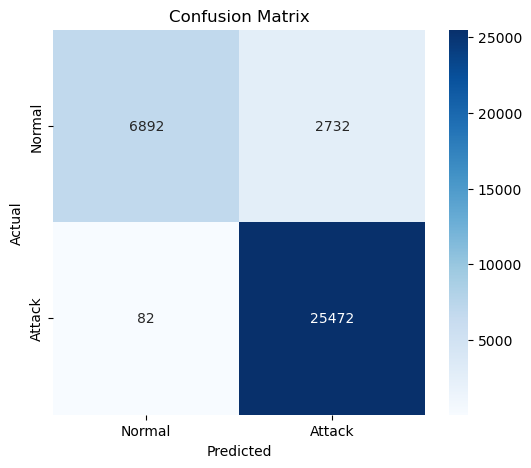

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


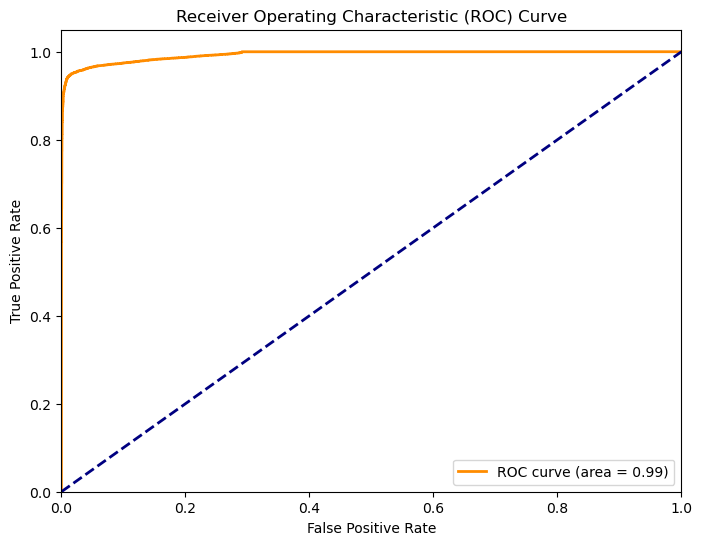

In [313]:
model = create_fcnn(activation='tanh', neuron_count_array=[64, 32])
train_model_cnn(model, optimizer='sgd')
evaluate_model(model, X_test)

### FCNN, sigmoid, 64->32, Adam

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 531us/step - accuracy: 0.9348 - loss: 0.1895 - val_accuracy: 0.9999 - val_loss: 0.0061
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.9732 - loss: 0.0670 - val_accuracy: 0.9996 - val_loss: 0.0062
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - accuracy: 0.9752 - loss: 0.0599 - val_accuracy: 0.9983 - val_loss: 0.0078
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9765 - loss: 0.0554 - val_accuracy: 0.9985 - val_loss: 0.0070
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
Confusion Matrix:
 [[ 6833  2791]
 [  148 25406]]
Precision: 0.9010178387771749
Recall: 0.9942083431165375
F1-Score: 0.9453219474986512


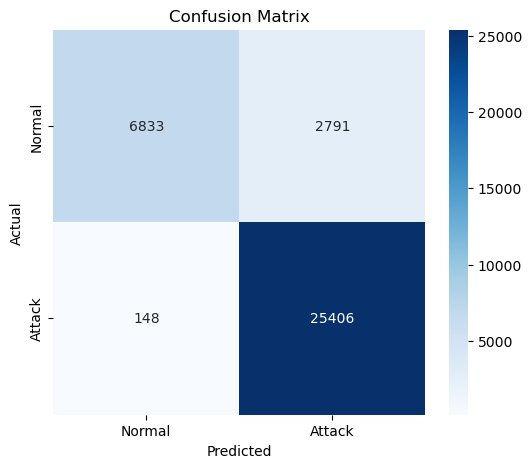

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step


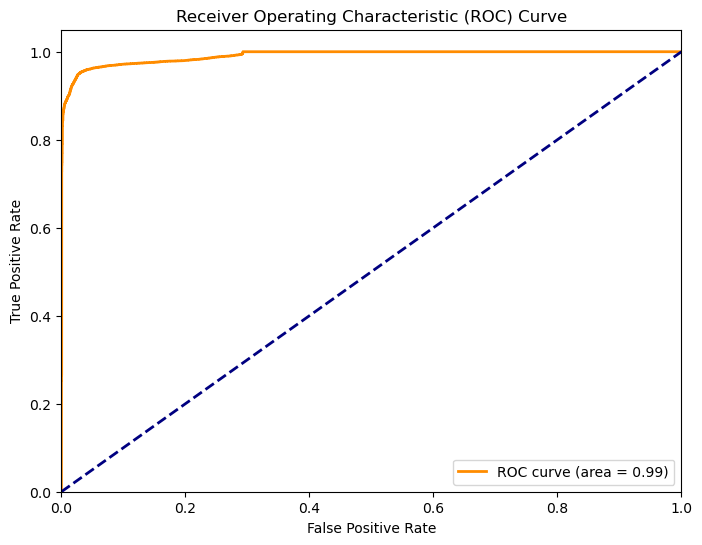

In [314]:
model = create_fcnn(activation='sigmoid', neuron_count_array=[64, 32])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### FCNN, sigmoid, 64->32, SGD

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6785 - loss: 0.5887 - val_accuracy: 1.0000 - val_loss: 0.1531
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.9660 - loss: 0.3014 - val_accuracy: 0.9999 - val_loss: 0.0397
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - accuracy: 0.9724 - loss: 0.1529 - val_accuracy: 0.9999 - val_loss: 0.0227
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - accuracy: 0.9731 - loss: 0.1244 - val_accuracy: 0.9999 - val_loss: 0.0176
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step - accuracy: 0.9716 - loss: 0.1169 - val_accuracy: 1.0000 - val_loss: 0.0147
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 441us/step - accuracy: 0.9710 - loss: 0.1070 - val_accuracy: 1.0000 - val_loss: 0.0120
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - accuracy: 0.9724 - loss: 0.0987 - val_accuracy: 0.9999 - val_loss: 0.0109
Epoch 8/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - accuracy: 0.9731 - loss: 0.09

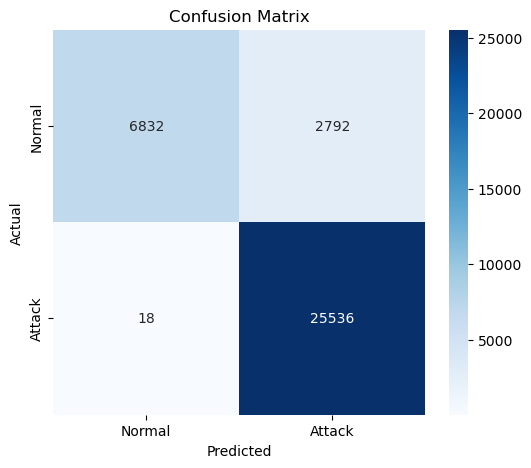

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


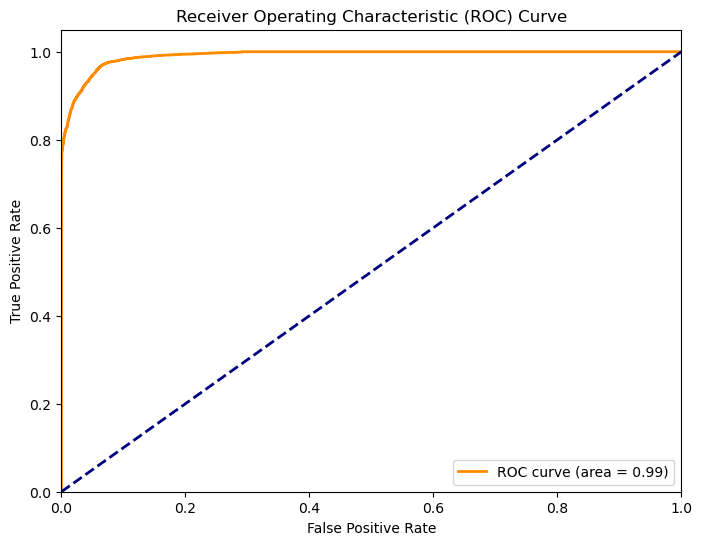

In [315]:
model = create_fcnn(activation='sigmoid', neuron_count_array=[64, 32])
train_model_cnn(model, optimizer='sgd')
evaluate_model(model, X_test)

### FCNN, ReLU, 64, Adam

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9535 - loss: 0.1442 - val_accuracy: 0.9999 - val_loss: 0.0052
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - accuracy: 0.9746 - loss: 0.0585 - val_accuracy: 0.9999 - val_loss: 0.0030
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.9766 - loss: 0.0565 - val_accuracy: 0.9979 - val_loss: 0.0075
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - accuracy: 0.9772 - loss: 0.0540 - val_accuracy: 0.9994 - val_loss: 0.0044
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.9785 - loss: 0.0516 - val_accuracy: 0.9994 - val_loss: 0.0041
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
Confusion Matrix:
 [[ 6873  2751]
 [   23 25531]]
Precision: 0.9027296513683615
Recall: 0.9990999452140565
F1-Score: 0.9484731406493796


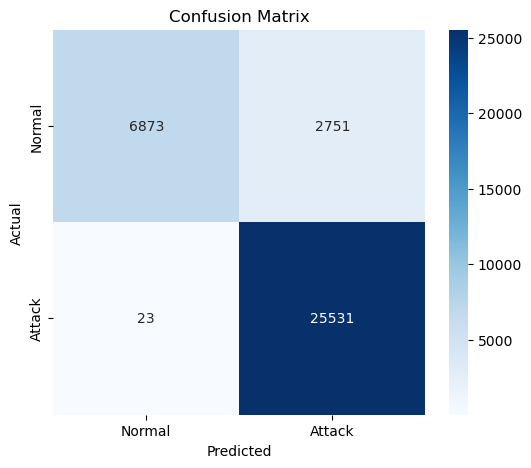

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


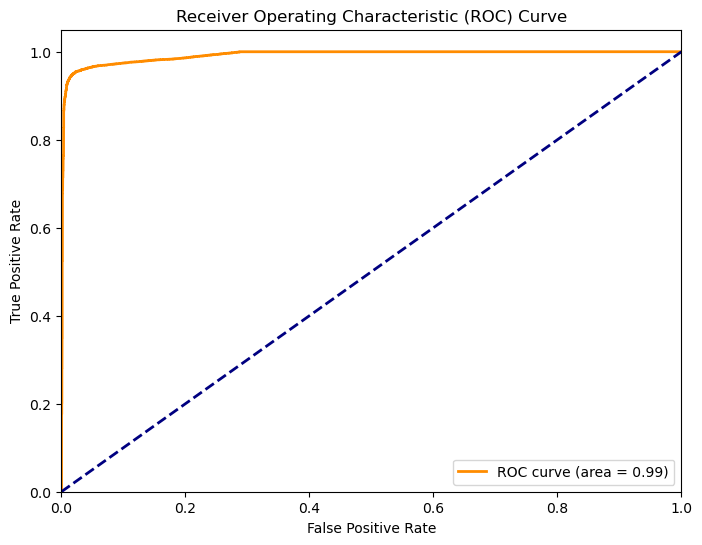

In [302]:
model = create_fcnn(activation='relu', neuron_count_array=[64])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### FCNN, ReLU, 64, SGD

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.9305 - loss: 0.2384 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.9717 - loss: 0.0932 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accuracy: 0.9733 - loss: 0.0795 - val_accuracy: 0.9999 - val_loss: 0.0083
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.9718 - loss: 0.0781 - val_accuracy: 0.9999 - val_loss: 0.0080
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - accuracy: 0.9740 - loss: 0.0712 - val_accuracy: 0.9999 - val_loss: 0.0074
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - accuracy: 0.9720 - loss: 0.0714 - val_accuracy: 0.9999 - val_loss: 0.0084
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - accuracy: 0.9733 - loss: 0.0662 - val_accuracy: 0.9999 - val_loss: 0.0073
Epoch 8/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.9721 - loss: 0.06

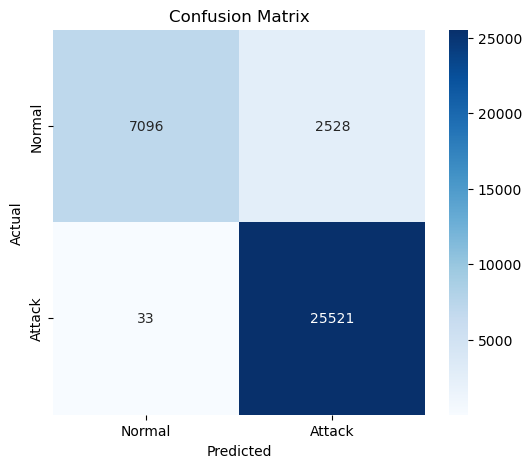

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


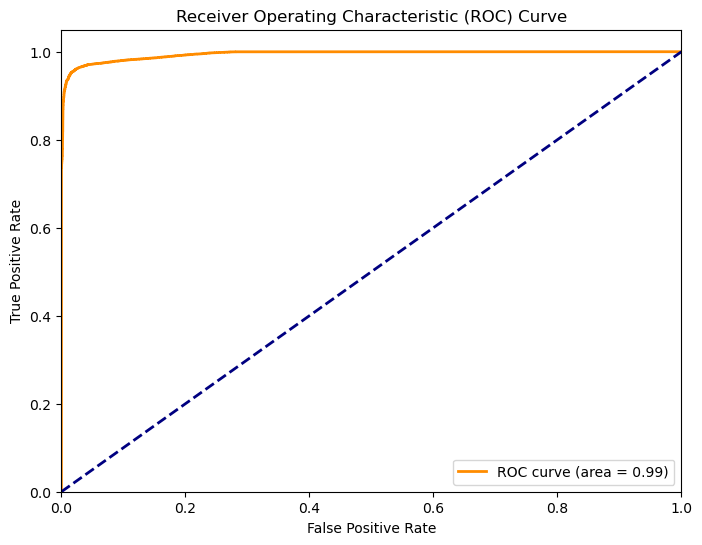

In [303]:
model = create_fcnn(activation='relu', neuron_count_array=[64])
train_model_cnn(model, optimizer='sgd')
evaluate_model(model, X_test)

### FCNN Summary:
On average, layer count and size seemed to have little impact on the results (if anything, fewer layers often returned greater results). Sigmoid paired with Adam had the lowest amount of false positives, but let too many actual attacks slip under the radar. Comparatively, ReLU seemed to have lower type II errors on average, while having more type I (false positive) errors. Sigmoid was the least predictable of the activations, which is consistent behavior with the previous project. ReLU seems to be the most consistent, with tanh fitting somewhere in between the two.

### CNN, ReLU, 64->32, Adam, 2 kernels, size 3

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9636 - loss: 0.1020 - val_accuracy: 0.9985 - val_loss: 0.0061
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9782 - loss: 0.0544 - val_accuracy: 0.9955 - val_loss: 0.0106
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9785 - loss: 0.0519 - val_accuracy: 0.9995 - val_loss: 0.0030
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9790 - loss: 0.0491 - val_accuracy: 0.9952 - val_loss: 0.0110
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9806 - loss: 0.0475 - val_accuracy: 0.9947 - val_loss: 0.0098
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9800 - loss: 0.0451 - val_accuracy: 0.9966 - val_loss: 0.0075
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step
Confusion Matrix:
 [[ 7317  2307]
 [   14 25540]]
Precision: 0.9171544511078392
Recall: 0.9994521405650779
F1-Score: 0.9565363944495422


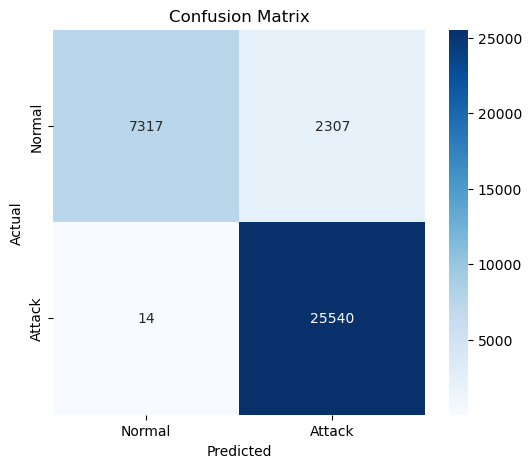

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step


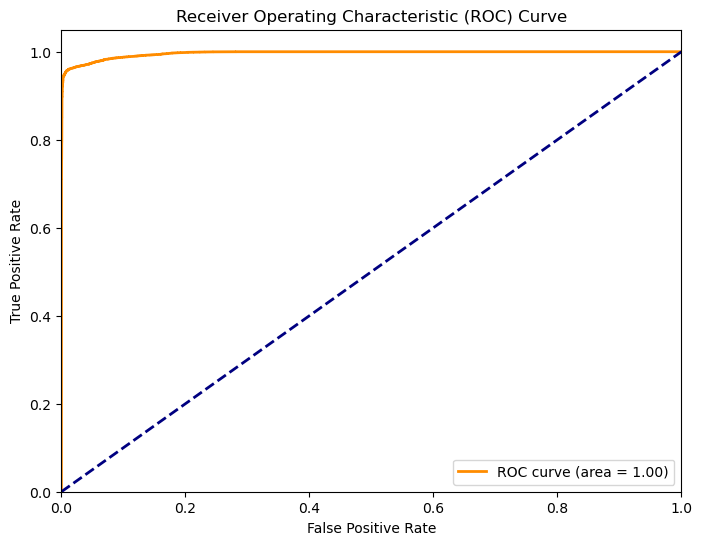

In [304]:
model = create_cnn(activation='relu', neuron_count_array=[64,32], kernel_size_array=[3,3])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### CNN, ReLU, 64->32, Adam, 1 kernel, size 5

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9703 - loss: 0.0920 - val_accuracy: 1.0000 - val_loss: 9.5834e-04
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9755 - loss: 0.0560 - val_accuracy: 0.9986 - val_loss: 0.0051
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9780 - loss: 0.0516 - val_accuracy: 0.9967 - val_loss: 0.0087
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9792 - loss: 0.0503 - val_accuracy: 0.9991 - val_loss: 0.0037
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step
Confusion Matrix:
 [[ 6863  2761]
 [   24 25530]]
Precision: 0.902407125941112
Recall: 0.9990608123972764
F1-Score: 0.9482774630884947


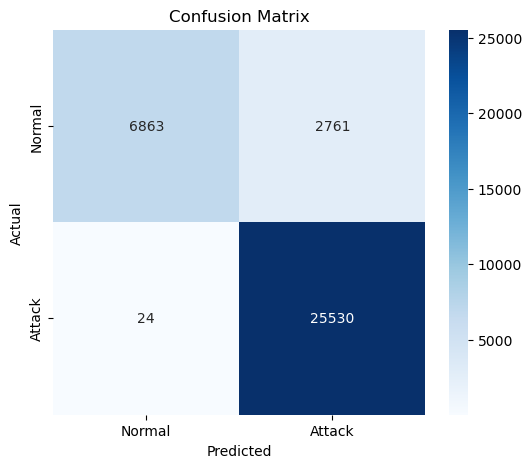

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step


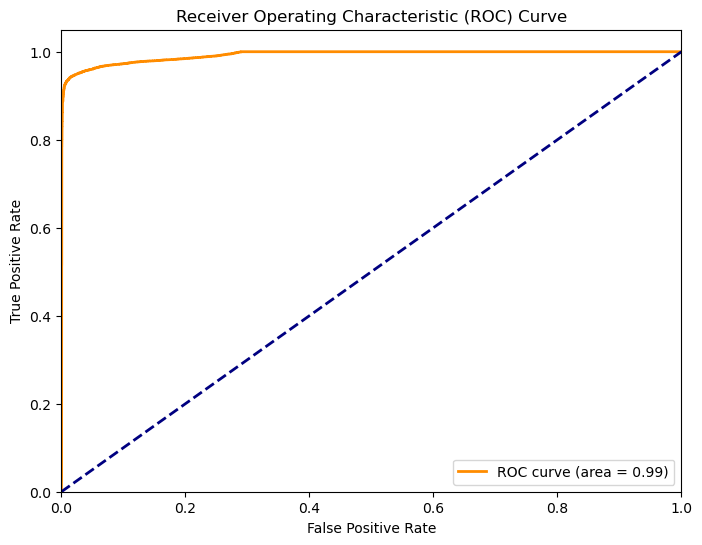

In [305]:
model = create_cnn(activation='relu', neuron_count_array=[64,32], kernel_size_array=[5])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### CNN, tanh, 64->32, Adam, 2 kernels, size 3

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9688 - loss: 0.0908 - val_accuracy: 0.9991 - val_loss: 0.0050
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9760 - loss: 0.0575 - val_accuracy: 0.9976 - val_loss: 0.0100
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9781 - loss: 0.0528 - val_accuracy: 0.9999 - val_loss: 0.0034
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9770 - loss: 0.0537 - val_accuracy: 0.9990 - val_loss: 0.0046
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9773 - loss: 0.0532 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9774 - loss: 0.0525 - val_accuracy: 0.9998 - val_loss: 0.0021
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9780 - loss: 0.0513 - val_accuracy: 0.9976 - val_loss: 0.0063
Epoch 8/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9781 - loss: 0.0528 - val_accurac

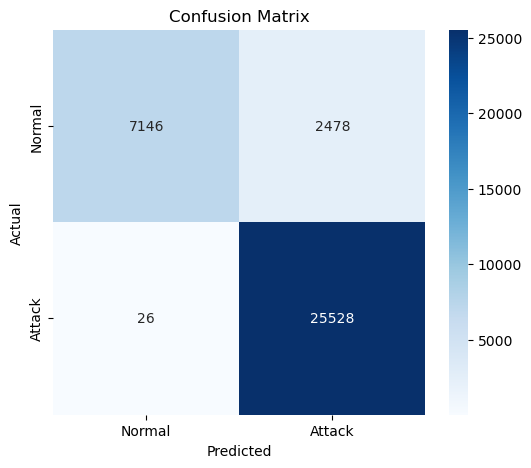

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step


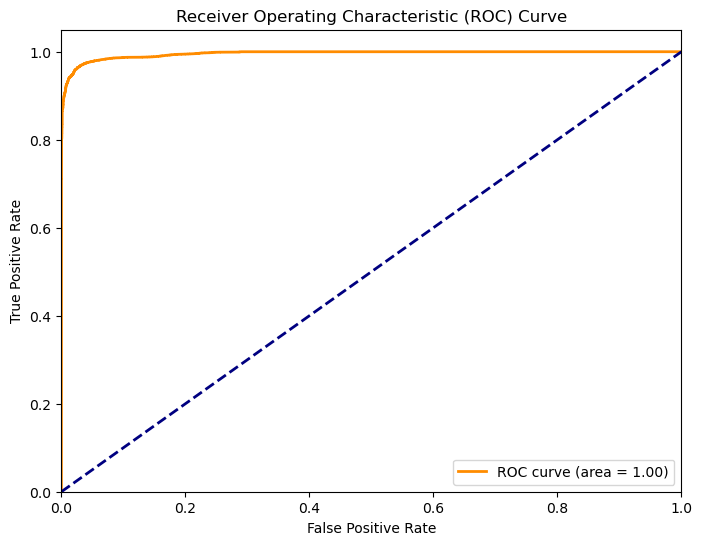

In [306]:
model = create_cnn(activation='tanh', neuron_count_array=[64,32], kernel_size_array=[3,3])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### CNN, tanh, 64->32, Adam, 1 kernel, size 5

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9676 - loss: 0.0874 - val_accuracy: 0.9991 - val_loss: 0.0067
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9771 - loss: 0.0553 - val_accuracy: 0.9988 - val_loss: 0.0063
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9764 - loss: 0.0542 - val_accuracy: 0.9970 - val_loss: 0.0075
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9777 - loss: 0.0524 - val_accuracy: 0.9980 - val_loss: 0.0056
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9779 - loss: 0.0511 - val_accuracy: 0.9988 - val_loss: 0.0050
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9781 - loss: 0.0508 - val_accuracy: 0.9971 - val_loss: 0.0066
Epoch 7/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9780 - loss: 0.0492 - val_accuracy: 0.9974 - val_loss: 0.0053
Epoch 8/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9788 - loss: 0.0487 - val_accurac

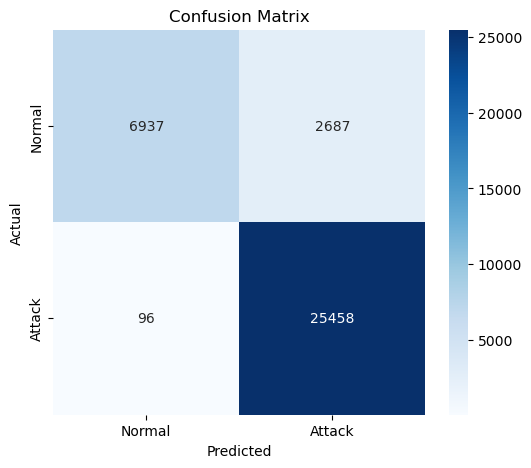

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step


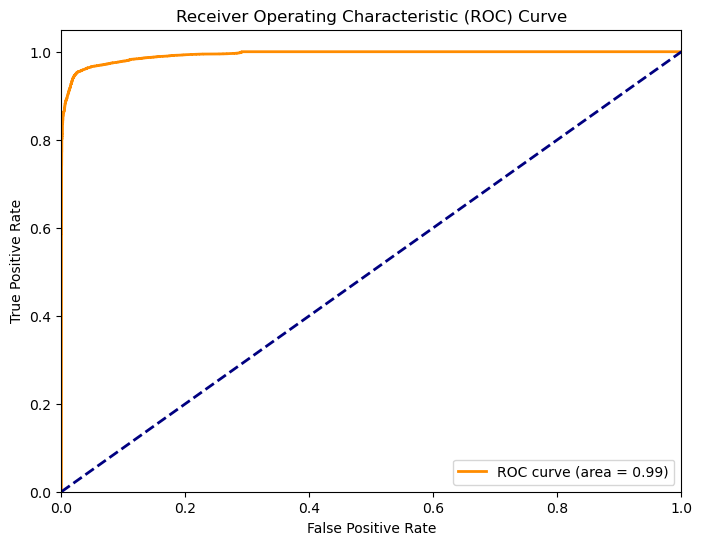

In [307]:
model = create_cnn(activation='tanh', neuron_count_array=[64,32], kernel_size_array=[5])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### CNN, sigmoid, 64->32, Adam, 2 kernels, size 3

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8676 - loss: 0.2938 - val_accuracy: 0.9998 - val_loss: 0.0092
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9743 - loss: 0.0729 - val_accuracy: 0.9996 - val_loss: 0.0051
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9763 - loss: 0.0599 - val_accuracy: 0.9974 - val_loss: 0.0089
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9772 - loss: 0.0551 - val_accuracy: 0.9967 - val_loss: 0.0077
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9785 - loss: 0.0529 - val_accuracy: 0.9983 - val_loss: 0.0070
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step
Confusion Matrix:
 [[ 6868  2756]
 [   19 25535]]
Precision: 0.9025838605917076
Recall: 0.9992564764811771
F1-Score: 0.9484631813538862


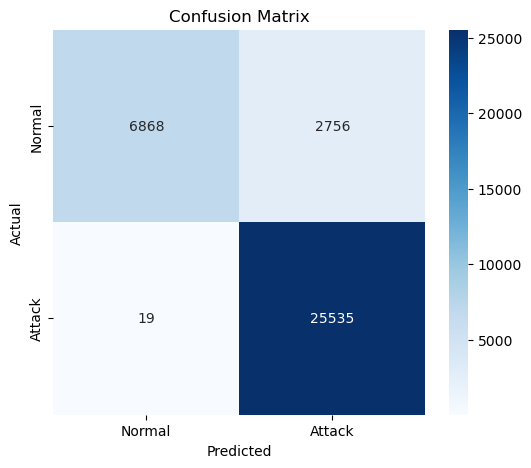

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step


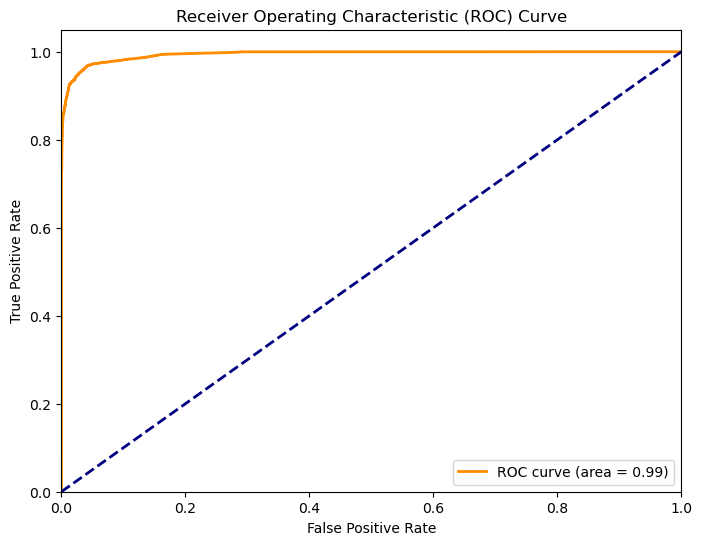

In [308]:
model = create_cnn(activation='sigmoid', neuron_count_array=[64,32], kernel_size_array=[3,3])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### CNN, sigmoid, 64->32, Adam, 1 kernel, size 5

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9216 - loss: 0.2081 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9729 - loss: 0.0815 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9743 - loss: 0.0698 - val_accuracy: 0.9973 - val_loss: 0.0094
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9745 - loss: 0.0632 - val_accuracy: 0.9914 - val_loss: 0.0166
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step
Confusion Matrix:
 [[ 6813  2811]
 [    0 25554]]
Precision: 0.9008989952406135
Recall: 1.0
F1-Score: 0.9478662438101597


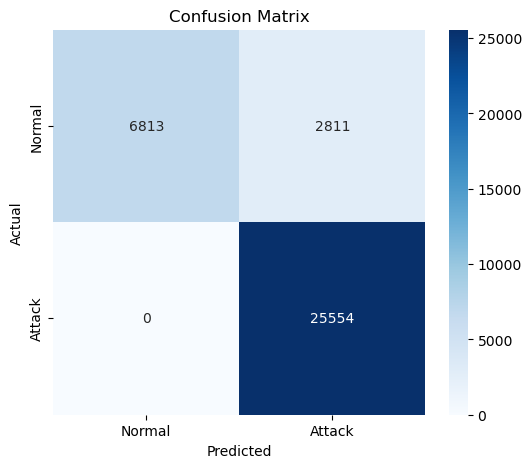

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step


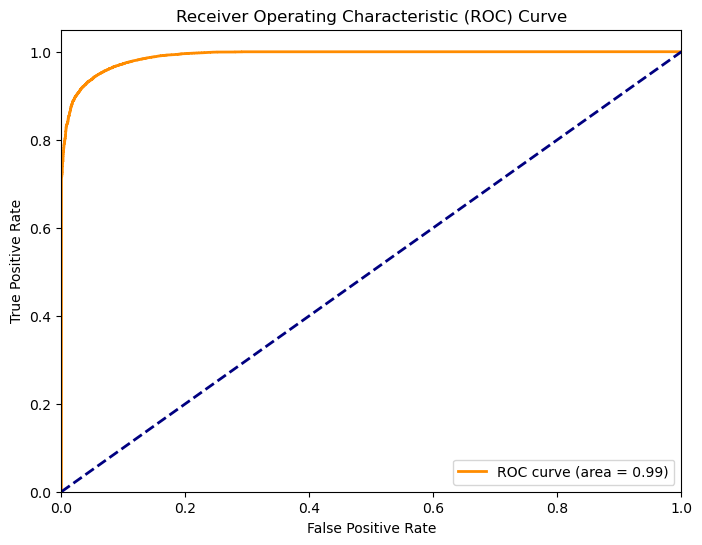

In [309]:
model = create_cnn(activation='sigmoid', neuron_count_array=[64,32], kernel_size_array=[5])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### CNN, ReLU, 64, Adam, 3 kernels, size 1

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9603 - loss: 0.1177 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9764 - loss: 0.0624 - val_accuracy: 0.9984 - val_loss: 0.0052
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9780 - loss: 0.0538 - val_accuracy: 0.9999 - val_loss: 0.0059
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9781 - loss: 0.0519 - val_accuracy: 0.9990 - val_loss: 0.0034
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
 [[ 6829  2795]
 [    4 25550]]
Precision: 0.9013935438348916
Recall: 0.9998434687328794
F1-Score: 0.9480695374682276


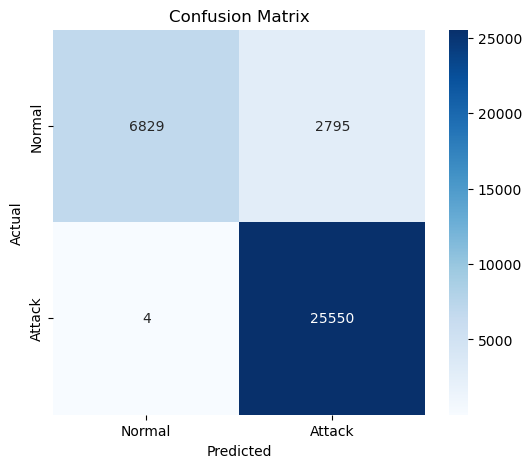

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


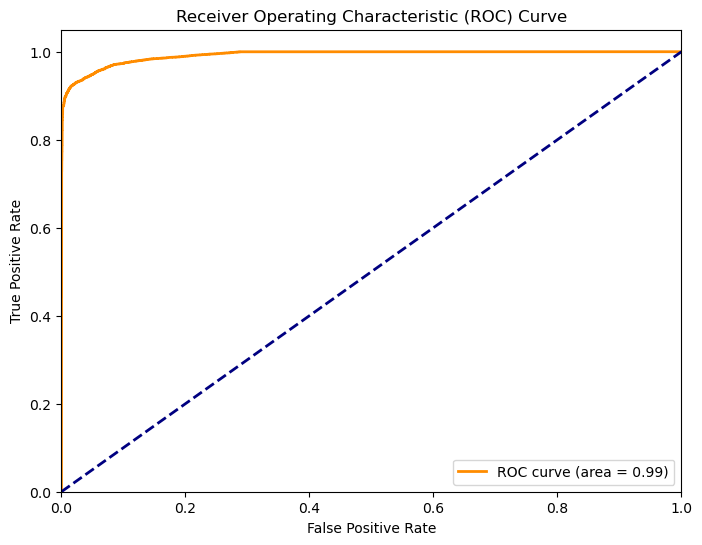

In [310]:
model = create_cnn(activation='relu', neuron_count_array=[64,32], kernel_size_array=[1,1,1])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### CNN, ReLU, 64, Adam, 3 kernels, size 3

Epoch 1/50


c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2029/2029 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9581 - loss: 0.1163 - val_accuracy: 0.9965 - val_loss: 0.0082
Epoch 2/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9779 - loss: 0.0555 - val_accuracy: 0.9979 - val_loss: 0.0057
Epoch 3/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9788 - loss: 0.0498 - val_accuracy: 0.9990 - val_loss: 0.0029
Epoch 4/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9792 - loss: 0.0487 - val_accuracy: 0.9962 - val_loss: 0.0073
Epoch 5/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9805 - loss: 0.0489 - val_accuracy: 0.9967 - val_loss: 0.0066
Epoch 6/50
2029/2029 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9796 - loss: 0.0463 - val_accuracy: 0.9978 - val_loss: 0.0061
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
 [[ 7267  2357]
 [   17 25537]]
Precision: 0.9155015415501542
Recall: 0.9993347421147374
F1-Score: 0.9555829965574015


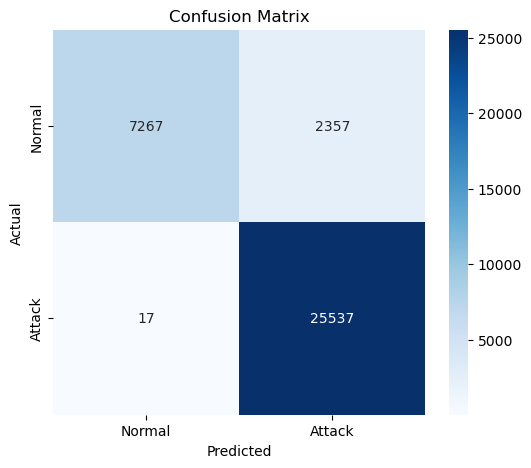

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


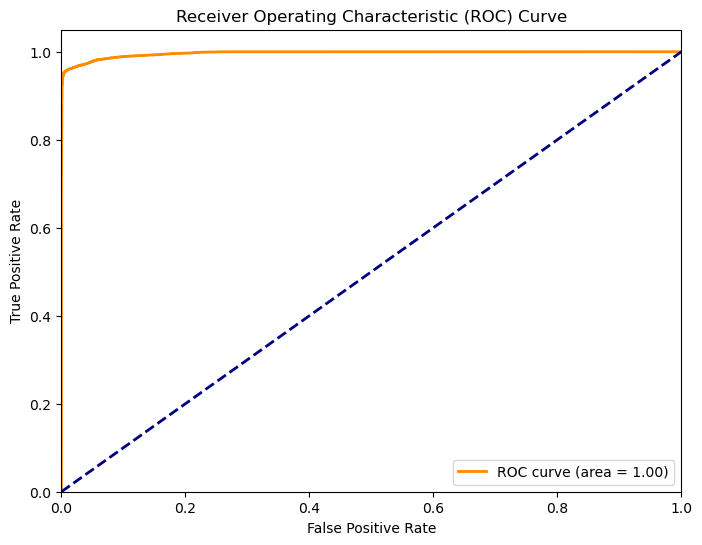

In [311]:
model = create_cnn(activation='relu', neuron_count_array=[64,32], kernel_size_array=[3,3,3])
train_model_cnn(model, optimizer='adam')
evaluate_model(model, X_test)

### CNN Summary:
The most interesting result was that sigmoid with 1 kernel size 5 was able to achieve 0 Type II errors. This is likely a fluke, but impressive nonetheless. Overall, the CNN models seem more able to reduce Type II errors over their FCNN counterparts, which is certainly better for real world applications.